In [43]:
def get_child_data():
    # Function to get feature data on children
    return {
        "child1": {"age": 10, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child2": {"age": 9, "gender": "F", "health_consideration": "very health conscious", "favorite_cuisine": "Italian"},
        "child3": {"age": 9, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "Italian"},
        "child4": {"age": 9, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child5": {"age": 11, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "Italian"},
        "child6": {"age": 11, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child7": {"age": 9, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "Italian"},
        "child8": {"age": 9, "gender": "F", "health_consideration": "very health conscious", "favorite_cuisine": "Italian"},
        "child9": {"age": 10, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child10": {"age": 11, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child11": {"age": 9, "gender": "F", "health_consideration": "moderately health conscious", "favorite_cuisine": "Italian"},
        "child12": {"age": 9, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child13": {"age": 9, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child14": {"age": 10, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "Seafood"},
        "child15": {"age": 11, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child16": {"age": 11, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child17": {"age": 9, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Italian"},
        "child18": {"age": 9, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child19": {"age": 9, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child20": {"age": 10, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "BBQ"},
        "child21": {"age": 10, "gender": "F", "health_consideration": "very health conscious", "favorite_cuisine": "BBQ"},
        "child22": {"age": 9, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "BBQ"},
        "child23": {"age": 9, "gender": "F", "health_consideration": "moderately health conscious", "favorite_cuisine": "BBQ"},
        "child24": {"age": 9, "gender": "M", "health_consideration": "don't care", "favorite_cuisine": "BBQ"},
        "child25": {"age": 11, "gender": "F", "health_consideration": "very health conscious", "favorite_cuisine": "BBQ"},
        "child26": {"age": 11, "gender": "M", "health_consideration": "moderately health conscious", "favorite_cuisine": "BBQ"},
        "child27": {"age": 9, "gender": "F", "health_consideration": "moderately health conscious", "favorite_cuisine": "Seafood"},
        "child28": {"age": 9, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Seafood"},
        "child29": {"age": 9, "gender": "M", "health_consideration": "very health conscious", "favorite_cuisine": "Italian"},
        "child30": {"age": 10, "gender": "F", "health_consideration": "don't care", "favorite_cuisine": "Italian"}
    }

In [52]:
import random
from utils.process_data import get_data

def initialize_children_data(child_features, data_file="data.csv", seed=None):
    random.seed(seed)
    children_data = {}
    
    # Load the ingredient data
    ingredient_df = get_data(data_file)
    
    # Base probabilities for like, neutral, and dislike
    base_probabilities = {"like": 0.3, "neutral": 0.5, "dislike": 0.2}
    
    # Factors affecting preferences with modifier values
    health_consideration_modifiers = {
        "very health conscious": {"healthy": 1.2, "average": 1, "unhealthy": 0.8},
        "moderately health conscious": {"healthy": 1.1, "average": 1, "unhealthy": 0.9},
        "don't care": {"healthy": 0.8, "average": 1, "unhealthy": 1.2},
    }
    
    favorite_cuisine_modifiers = {
        "BBQ": {"Meat and meat products": 1.2},
        "Seafood": {"Fish seafood amphibians reptiles and invertebrates": 1.2},
        "Italian": {"Anchovies": 1.2, "Aubergines": 1.2, "Noodles": 1.2, "Pasta plain (not stuffed) uncooked": 1.2, "Pasta wholemeal": 1.2, "Tomatoes": 1.2},
    }
    
    taste_modifiers = {
        "Sweet": 1.1,
        "Salty": 1.1,
        "Sour": 0.8,
        "Earthy": 0.8,
        "Misc": 1,
    }
    
    colour_modifiers = {
        "Red": 1.1,
        "Green": 1.1,
        "Yellow": 1.05,
        "Orange": 1.05,
        "Pink": 1,
        "Purple": 1,
        "White": 0.95,
        "Brown": 0.95,
    }
    
    gender_modifiers = {
        "M": 0.9,
        "F": 1.1,
    }
    
    age_modifiers = {
        9: 0.9,
        10: 1,
        11: 1.1,
    }
    
    texture_modifiers = {
        "Crunchy": 0.9,
        "Soft": 1.1,
        "Soft/Crunchy": 0.8,
        "Firm": 1.1,
        "Leafy": 1,
        "Grainy": 1,
        "Liquid": 1,
        "Powdery": 1,
    }
    
    other_modifiers = {
        "fruit_factor": 1.1,
        "vegetables_factor": {"M": 0.9, "F": 1},
        "meat_factor": {"M": 1, "F": 0.9},
    }
    
    vegetable_groups = {
        "Group A": ["Tomatoes", "Sweet corn", "Sweet potatoes", "Carrots"],
        "Group B": ["Onions", "Spring onions", "Pepper"],
        "Group C": ["Cauliflowers"],
        "Group D": ["Courgettes", "Spinaches", "Curly kales", "Peas"],
        "Group E": ["Beetroots", "Lettuces (generic)", "Broccoli"],
        "Group F": ["Aubergines", "Cucumber", "White cabbage", "Savoy cabbages", "Red cabbage", "Runner beans (with pods)"],
    }
    
    group_probabilities_modifiers = {
        "Group A": {"like": 1.2, "neutral": 0.8, "dislike": 0.7},
        "Group B": {"like": 1.1, "neutral": 1, "dislike": 0.9},
        "Group C": {"like": 0.8, "neutral": 1, "dislike": 1.2},
        "Group D": {"like": 1, "neutral": 1, "dislike": 1},
        "Group E": {"like": 0.9, "neutral": 1, "dislike": 1.1},
        "Group F": {"like": 0.9, "neutral": 1, "dislike": 1.1},
    }

    # Initialize preferences for each child
    for child_key, features in child_features.items():
        # Extract child-specific features
        health_consideration = features["health_consideration"]
        age = features["age"]
        gender = features["gender"]
        favorite_cuisine = features["favorite_cuisine"]

        # Get the modifier values for the child's health consideration, age, and gender
        health_modifiers = health_consideration_modifiers[health_consideration]
        age_modifier = age_modifiers[age]
        gender_modifier = gender_modifiers[gender]

        preferences = {"likes": [], "neutral": [], "dislikes": []}

        for i, row in ingredient_df.iterrows():
            ingredient = row["Category7"]
            health_category = row["Healthy"]

            # Calculate modifiers based on various factors
            health_mod = health_modifiers[health_category]
            favorite_mod = favorite_cuisine_modifiers.get(favorite_cuisine, {}).get(row["Category1"], 1)
            taste_mod = taste_modifiers.get(row["Taste"], taste_modifiers["Misc"])
            colour_mod = colour_modifiers[row["Colour"]]
            texture_mod = texture_modifiers[row["Texture"]]

            # Determine the vegetable group and get the group probability modifiers
            group_name = next((group for group, ingredients in vegetable_groups.items() if ingredient in ingredients), None)
            group_modifiers = group_probabilities_modifiers[group_name] if group_name else {"like": 1, "neutral": 1, "dislike": 1}
            
            # Calculate other modifiers
            fruit_mod = other_modifiers["fruit_factor"] if row["Category1"] == "Fruits and fruit products" else 1
            vegetable_mod = other_modifiers["vegetables_factor"][gender] if row["Category1"] == "Vegetables and vegetable products" else 1
            meat_mod = other_modifiers["meat_factor"][gender] if row["Category1"] == "Meat and meat products" else 1

            # Calculate the overall probabilities by applying modifiers to the base probabilities
            like_probability = base_probabilities["like"] * health_mod * favorite_mod * taste_mod * colour_mod * gender_modifier * age_modifier * texture_mod * group_modifiers["like"] * fruit_mod * vegetable_mod * meat_mod
            neutral_probability = base_probabilities["neutral"] * health_mod * favorite_mod * taste_mod * colour_mod * gender_modifier * age_modifier * texture_mod * group_modifiers["neutral"] * fruit_mod * vegetable_mod * meat_mod
            dislike_probability = base_probabilities["dislike"] * health_mod * favorite_mod * taste_mod * colour_mod * gender_modifier * age_modifier * texture_mod * group_modifiers["dislike"] * fruit_mod * vegetable_mod * meat_mod
            
            # Normalize the probabilities
            total = like_probability + neutral_probability + dislike_probability
            like_probability /= total
            neutral_probability /= total
            dislike_probability /= total
            
            print(ingredient, like_probability, neutral_probability, dislike_probability)

            # Determine the preference based on the calculated probabilities
            rand_val = random.random()
            if rand_val < like_probability:
                preferences["likes"].append(ingredient)
            elif rand_val < like_probability + neutral_probability:
                preferences["neutral"].append(ingredient)
            else:
                preferences["dislikes"].append(ingredient)

        children_data[child_key] = preferences

    return children_data


In [56]:

data = initialize_children_data(get_child_data())

Successfully read 136 lines from the file. Loaded 135 ingredients.


In [62]:
data['child1']

{'likes': ['Almonds',
  'Anchovies',
  'Apples',
  'Asparagus',
  'Bacon',
  'Basil',
  'Bitter chocolate',
  'Carrots',
  'Cashew nuts',
  'Celeries',
  'Chicken fresh meat',
  'Chocolate coated confectionery',
  'Cod',
  'Cream plain',
  'Edible crab',
  'Ham pork',
  'Herrings',
  'Honey',
  'Jerusalem artichokes',
  'Lamb fresh meat',
  'Limes',
  'Mascarpone',
  'New potatoes',
  'Oregano',
  'Palm oil/fat',
  'Parmesan',
  'Pasta plain (not stuffed) uncooked',
  'Pasta wholemeal',
  'Peanuts',
  'Pistachios',
  'Radishes',
  'Raspberries',
  'Savoy cabbages',
  'Sunflower seeds',
  'Sweet potatoes',
  'Tomatoes',
  'White sugar',
  'Yoghurt cow milk plain'],
 'neutral': ['Beetroots',
  'Blueberries',
  'Brazil nuts',
  'Brussels sprouts',
  'Butter',
  'Cheese cheddar',
  'Chickpeas (dry)',
  'Chili peppers',
  'Coalfish',
  'Coconuts',
  'Common banana',
  'Common bean sprouts',
  'Common mushrooms',
  'Courgettes',
  'Couscous',
  'Cow milk semi skimmed (half fat)',
  'Cow milk

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_models(X, y, n_splits=5):

    # Define scorers with zero_division=0 to handle undefined metric cases
    scorers = {
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
        'accuracy': make_scorer(accuracy_score)
    }

    # Evaluate models using cross-validation
    results = []
    accuracy_scores = {}
    for name, model in get_models().items():
        for scorer_name, scorer in scorers.items():
            score = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=n_splits), scoring=scorer)
            results.append({
                "Model": name,
                "Metric": scorer_name,
                "Score": score.mean()
            })
            if scorer_name == 'accuracy':
                accuracy_scores[name] = score.mean()

    # Convert results to DataFrame for easy comparison
    results_df = pd.DataFrame(results)
    
    return results_df, accuracy_scores

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def get_models():
    # Initialize the models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200),
        "Support Vector Machine": SVC(),
        "XGBoost": XGBClassifier(eval_metric='logloss'),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=1),
        "Decision Tree": DecisionTreeClassifier()
    }
    return models

In [8]:
def get_ranked_models(results_df):
    # Rank models for each metric
    ranked_results = results_df.copy()
    ranked_results['Rank'] = ranked_results.groupby('Metric')['Score'].rank(ascending=False, method='min')

    # Convert results to DataFrame for easy comparison
    results_df_sorted = ranked_results.sort_values(by=['Metric', 'Rank'])

    print(results_df_sorted)
    
def get_confusion_matrix(X, y, accuracy_scores, models, label_encoder):
    # Identify the best model based on accuracy
    best_model_name = max(accuracy_scores, key=accuracy_scores.get)
    best_model = models[best_model_name]

    # Fit the best model on the entire dataset and predict
    best_model.fit(X, y)
    y_pred = best_model.predict(X)

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.show()

Successfully read 137 lines from the file. Loaded 136 ingredients.
                     Model           Metric     Score  Rank
3      Logistic Regression         accuracy  0.433333   1.0
23                AdaBoost         accuracy  0.433333   1.0
15           Random Forest         accuracy  0.392063   3.0
7   Support Vector Machine         accuracy  0.392063   4.0
31           Decision Tree         accuracy  0.384127   5.0
11                 XGBoost         accuracy  0.371429   6.0
19       Gradient Boosting         accuracy  0.368254   7.0
27     K-Nearest Neighbors         accuracy  0.334921   8.0
22                AdaBoost         f1_macro  0.420713   1.0
2      Logistic Regression         f1_macro  0.406997   2.0
6   Support Vector Machine         f1_macro  0.395316   3.0
30           Decision Tree         f1_macro  0.387966   4.0
14           Random Forest         f1_macro  0.385720   5.0
10                 XGBoost         f1_macro  0.360114   6.0
18       Gradient Boosting       

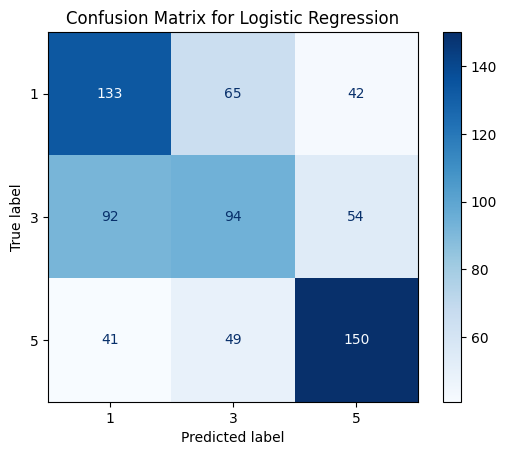

In [15]:

from utils.process_data import get_data
from models.preferences.data_utils import prepare_ml_data, get_child_data, initialize_children_data

child_data = get_child_data()
ingredient_df = get_data("data.csv")
preferences = initialize_children_data(child_data, seed=10)


X, y, label_encoder, preprocessor = prepare_ml_data(preferences, ingredient_df, child_data)

results_df, accuracy_scores = evaluate_models(X, y)

get_ranked_models(results_df)
models = get_models()
# Convert sparse matrix to dense format if necessary
X_dense = X.toarray() if hasattr(X, 'toarray') else X
from imblearn.over_sampling import SMOTE
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_dense, y)

get_confusion_matrix(X_resampled, y_resampled, accuracy_scores, models, label_encoder)

# from models.preferences.prediction import fit_random_forest_classifier

# rf_model = fit_random_forest_classifier(preferences, ingredient_df, child_data, apply_SMOTE=True, seed=10)


Successfully read 137 lines from the file. Loaded 136 ingredients.
                     Model           Metric     Score  Rank
3      Logistic Regression         accuracy  0.434921   1.0
15           Random Forest         accuracy  0.434921   1.0
23                AdaBoost         accuracy  0.431746   3.0
7   Support Vector Machine         accuracy  0.430159   4.0
19       Gradient Boosting         accuracy  0.420635   5.0
31           Decision Tree         accuracy  0.415873   6.0
11                 XGBoost         accuracy  0.395238   7.0
27     K-Nearest Neighbors         accuracy  0.366667   8.0
22                AdaBoost         f1_macro  0.423301   1.0
6   Support Vector Machine         f1_macro  0.416598   2.0
18       Gradient Boosting         f1_macro  0.408628   3.0
30           Decision Tree         f1_macro  0.404149   4.0
14           Random Forest         f1_macro  0.404101   5.0
2      Logistic Regression         f1_macro  0.398618   6.0
10                 XGBoost       

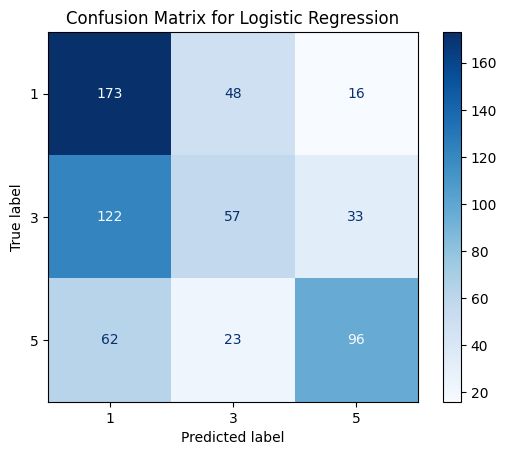

In [16]:
from utils.process_data import get_data
from models.preferences.data_utils import prepare_ml_data, get_child_data, initialize_children_data

child_data = get_child_data()
ingredient_df = get_data("data.csv")
preferences = initialize_children_data(child_data, seed=None)


X, y, label_encoder, preprocessor = prepare_ml_data(preferences, ingredient_df, child_data)

results_df, accuracy_scores = evaluate_models(X, y)

get_ranked_models(results_df)
models = get_models()
get_confusion_matrix(X, y, accuracy_scores, models, label_encoder)

# from models.preferences.prediction import fit_random_forest_classifier

# rf_model = fit_random_forest_classifier(preferences, ingredient_df, child_data, apply_SMOTE=True, seed=10)


In [50]:
import pandas as pd

data = {
    "Ingredient": [
        "White sugar", "Honey", "Chocolate coated confectionery", "Bitter chocolate", "Common banana", "Table grapes",
        "Sweet potatoes", "Yoghurt cow milk flavoured", "Mango", "Cherries", "Apples", "Pears",
        "Kiwi fruits (green red yellow)", "Palm oil/fat", "Pineapples", "Papayas", "Nectarines", "Plums", "Blueberries",
        "Oranges sweet", "Pistachios", "Carrots", "Grapefruits", "Watermelons", "Beetroots", "Onions", "Strawberries",
        "Passionfruits", "Cashew nuts", "Chickpeas (dry)", "Peas", "Parsnip roots", "Swedes", "Mascarpone", "White cabbage",
        "Raspberries", "Turnips", "Yoghurt cow milk plain", "Almonds", "Pepper", "Chili peppers", "Hazelnuts",
        "Savoy cabbages", "Coconuts", "Pasta plain (not stuffed) uncooked", "Limes", "Red cabbage", "Brussels sprouts",
        "Tomatoes", "Wheat bread and rolls white (refined flour)", "Creme fraiche cheese", "Sour cream", "Spring onions",
        "Kidney beans", "Sweet corn", "Wheat bread and rolls brown or wholemeal", "Cauliflowers", "Brazil nuts",
        "Common bean sprouts", "Wheat wholemeal flour", "Leeks", "Aubergines", "Courgettes", "Broccoli", "Asparagus",
        "Sunflower seeds", "Breakfast-type sausage", "Cream plain", "Runner beans (with pods)", "Lettuces (generic)",
        "Wheat flour white", "Garlic", "Radishes", "Lentils (dry)", "Peanuts", "Pumpkin seeds", "New potatoes", "Cucumber",
        "Mozzarella", "Curly kales", "Couscous", "Celeries", "Parsley", "Corianders", "Rhubarbs", "Potatoes", "Butter",
        "Ham pork", "Frankfurter sausage", "Anchovies", "Shrimps and prawns", "Traditional margarine", "Pig fresh meat",
        "Mackerel", "Eggs", "Salmons", "Lamb fresh meat", "Coalfish", "Duck fresh meat", "Hakes", "Trouts", "Turkey fresh meat",
        "Chicken fresh meat", "Avocados", "Deer red fresh meat", "Jerusalem artichokes", "Spinaches", "Rice grain brown",
        "Pasta wholemeal", "Rice grain", "Noodles", "Common mushrooms", "Rice grain long-grain", "Rosemary", "Oregano",
        "Basil", "Fish fingers breaded", "Buckwheat", "Bacon", "Cheese cheddar", "Edible crab", "Sea bass", "Cod", "Herrings",
        "Parmesan", "Tuna", "Haddock", "White chocolate", "Cow milk whole", "Cow ox or bull fresh meat",
        "Cow milk skimmed (low fat)", "Cow milk semi skimmed (half fat)", "Olive oil", "Sunflower seed oil edible",
        "Rape seed oil edible"
    ],
    "Texture": ['Granulated, crystalline', 'Thick, viscous', 'Smooth, crunchy (outer coating)', 'Hard, brittle', 'Soft, creamy', 'Juicy, firm', 'Firm (raw), soft (cooked)', 'Creamy, smooth', 'Juicy, fibrous', 'Juicy, firm', 'Crisp, juicy', 'Grainy, juicy', 'Juicy, slightly grainy', 'Solid (at room temperature), oily', 'Juicy, fibrous', 'Soft, smooth', 'Juicy, smooth', 'Juicy, firm', 'Juicy, soft', 'Juicy, segmented', 'Crunchy', 'Crunchy (raw), soft (cooked)', 'Juicy, segmented', 'Juicy, crisp', 'Firm (raw), soft (cooked)', 'Crunchy (raw), soft (cooked)', 'Juicy, soft', 'Juicy, seedy', 'Crunchy', 'Hard (dry), soft (cooked)', 'Firm (fresh), soft (cooked)', 'Firm (raw), soft (cooked)', 'Firm (raw), soft (cooked)', 'Creamy, smooth', 'Crunchy', 'Juicy, soft', 'Firm (raw), soft (cooked)', 'Creamy, smooth', 'Crunchy', 'Crunchy (raw), soft (cooked)', 'Crunchy (raw), soft (cooked)', 'Crunchy', 'Crunchy', 'Firm, fibrous', 'Hard, brittle', 'Juicy, firm', 'Crunchy', 'Firm (raw), soft (cooked)', 'Juicy, soft', 'Soft, airy', 'Creamy, smooth', 'Creamy, smooth', 'Crunchy', 'Firm (raw), soft (cooked)', 'Juicy, crunchy', 'Dense, chewy', 'Crunchy (raw), soft (cooked)', 'Crunchy', 'Crunchy', 'Powdery', 'Crunchy (raw), soft (cooked)', 'Firm (raw), soft (cooked)', 'Firm (raw), soft (cooked)', 'Crunchy (raw), soft (cooked)', 'Crunchy (raw), tender (cooked)', 'Crunchy', 'Firm, chewy', 'Creamy, smooth', 'Crunchy (raw), tender (cooked)', 'Crisp', 'Powdery', 'Firm (raw), soft (cooked)', 'Crunchy', 'Hard (dry), soft (cooked)', 'Crunchy', 'Crunchy', 'Firm (raw), soft (cooked)', 'Crisp, juicy', 'Soft, stretchy', 'Crisp', 'Grainy', 'Crunchy', 'Leafy', 'Leafy', 'Firm, fibrous', 'Firm (raw), soft (cooked)', 'Creamy, smooth', 'Firm, tender', 'Firm, chewy', 'Soft, oily', 'Firm, tender', 'Creamy, smooth', 'Firm, tender (cooked)', 'Firm, flaky', 'Firm (boiled), soft (raw)', 'Firm, flaky', 'Firm, tender (cooked)', 'Firm, flaky', 'Firm, tender (cooked)', 'Firm, flaky', 'Firm, flaky', 'Firm, tender (cooked)', 'Firm, tender (cooked)', 'Creamy, smooth', 'Firm, tender (cooked)', 'Crunchy (raw), soft (cooked)', 'Leafy', 'Firm, chewy (cooked)', 'Firm, chewy', 'Firm, tender (cooked)', 'Firm, tender (cooked)', 'Spongy', 'Firm, tender (cooked)', 'Leafy', 'Leafy', 'Leafy', 'Crispy (breaded coating), tender (inside)', 'Grainy', 'Crispy (cooked), chewy (raw)', 'Firm, crumbly', 'Firm, flaky', 'Firm, flaky', 'Firm, flaky', 'Firm, oily', 'Hard, crumbly', 'Firm, flaky', 'Firm, flaky', 'Smooth, creamy', 'Liquid, smooth', 'Firm, tender (cooked)', 'Liquid, smooth', 'Liquid, smooth', 'Liquid, smooth', 'Liquid, smooth', 'Liquid, smooth'],
    
    "Taste": ['Sweet', 'Sweet', 'Sweet, chocolatey', 'Bitter, rich', 'Sweet, mildly tangy', 'Sweet, juicy', 'Sweet, earthy', 'Sweet, tangy', 'Sweet, tropical', 'Sweet, tart', 'Sweet, slightly tart', 'Sweet, mild', 'Sweet, tangy', 'Neutral, slightly nutty', 'Sweet, tangy', 'Sweet, mild', 'Sweet, juicy', 'Sweet, slightly tart', 'Sweet, slightly tart', 'Sweet, citrusy', 'Nutty, slightly sweet', 'Sweet, earthy', 'Bitter, tangy', 'Sweet, refreshing', 'Earthy, sweet', 'Pungent, sweet (when cooked)', 'Sweet, slightly tart', 'Sweet, tangy', 'Nutty, slightly sweet', 'Nutty, earthy', 'Sweet, green', 'Sweet, nutty', 'Sweet, earthy', 'Creamy, mild', 'Mild, slightly sweet', 'Sweet, tart', 'Peppery, slightly sweet', 'Tangy, creamy', 'Nutty, mildly sweet', 'Spicy, pungent', 'Spicy, hot', 'Nutty, sweet', 'Mild, slightly sweet', 'Sweet, nutty', 'Neutral', 'Sour, tangy', 'Mild, slightly sweet', 'Bitter, nutty', 'Sweet, tangy', 'Mild, slightly sweet', 'Tangy, creamy', 'Tangy, creamy', 'Mild, slightly sweet', 'Earthy, slightly sweet', 'Sweet, juicy', 'Nutty, slightly sweet', 'Mild, slightly nutty', 'Nutty, creamy', 'Mild, slightly nutty', 'Nutty, slightly sweet', 'Mild, slightly sweet', 'Mild, slightly bitter', 'Mild, slightly sweet', 'Mild, slightly bitter', 'Earthy, slightly sweet', 'Nutty', 'Savory, salty', 'Creamy, mild', 'Mild, slightly sweet', 'Mild, slightly bitter', 'Neutral', 'Pungent, slightly sweet (when cooked)', 'Peppery, slightly sweet', 'Earthy, nutty', 'Nutty, slightly sweet', 'Nutty, slightly sweet', 'Earthy, slightly sweet', 'Mild, refreshing', 'Mild, creamy', 'Bitter, earthy', 'Mild, slightly nutty', 'Mild, slightly bitter', 'Fresh, slightly peppery', 'Citrusy, slightly peppery', 'Tart', 'Earthy, slightly sweet', 'Creamy, rich', 'Salty, savory', 'Salty, smoky', 'Salty, fishy', 'Sweet, slightly briny', 'Creamy, mild', 'Savory, rich', 'Oily, rich', 'Rich, mild', 'Rich, slightly oily', 'Savory, rich', 'Mild, slightly sweet', 'Rich, gamey', 'Mild, slightly sweet', 'Mild, slightly sweet', 'Mild, slightly sweet', 'Mild, slightly sweet', 'Creamy, nutty', 'Rich, gamey', 'Sweet, nutty', 'Earthy, slightly bitter', 'Nutty, slightly chewy', 'Nutty, slightly chewy', 'Mild, slightly sweet', 'Mild, slightly chewy', 'Earthy, umami', 'Mild, slightly sweet', 'Pine-like, slightly bitter', 'Herbal, slightly bitter', 'Sweet, slightly peppery', 'Savory, crispy', 'Nutty, slightly bitter', 'Salty, smoky', 'Savory, sharp', 'Sweet, briny', 'Mild, slightly sweet', 'Mild, slightly sweet', 'Salty, oily', 'Savory, nutty', 'Rich, meaty', 'Mild, slightly sweet', 'Sweet, creamy', 'Creamy, slightly sweet', 'Rich, savory', 'Mild, slightly sweet', 'Creamy, slightly sweet', 'Fruity, slightly bitter', 'Mild, slightly nutty', 'Mild, slightly nutty'],

    "Color": ['White', 'Golden', 'Various colors', 'Dark brown', 'Yellow', 'Green, red, or purple', 'Orange or purple', 'Various colors (depends on flavor)', 'Orange or yellow', 'Red', 'Red, green, or yellow', 'Green or yellow', 'Brown (outside), green, red, or yellow (inside)', 'Yellow or orange', 'Brown (outside), yellow (inside)', 'Orange', 'Red and yellow', 'Purple or red', 'Blue or purple', 'Orange', 'Green (nut), beige (shell)', 'Orange', 'Pink or red', 'Green (outside), red (inside)', 'Red or purple', 'White, yellow, or red', 'Red', 'Purple or yellow (outside), yellow (inside)', 'Beige', 'Beige', 'Green', 'Cream', 'Purple and yellow', 'White', 'Greenish-white', 'Red', 'Purple and white', 'White', 'Brown (nut), beige (inside)', 'Green, red, yellow, or orange', 'Red, green, yellow, or orange', 'Brown (nut), beige (inside)', 'Green', 'Brown (outside), white (inside)', 'Yellow', 'Green', 'Red or purple', 'Green', 'Red', 'Light brown', 'White', 'White', 'Green and white', 'Red or brown', 'Yellow', 'Brown', 'White', 'Brown (shell), cream (nut)', 'White', 'Brown', 'Green and white', 'Purple', 'Green or yellow', 'Green', 'Green', 'Gray (shell), white (inside)', 'Brown', 'White', 'Green', 'Green', 'White', 'White', 'Red and white', 'Brown, green, red, or yellow', 'Beige (nut), brown (shell)', 'Green', 'Light brown or yellow', 'Green', 'White', 'Green', 'Yellow', 'Green', 'Green', 'Green', 'Red or green', 'Brown or red (skin), white or yellow (inside)', 'Yellow', 'Pink', 'Brown', 'Silver', 'Pink or gray', 'Yellow', 'Pink', 'Silver', 'White or brown (shell), yellow (yolk), white (egg white)', 'Pink', 'Red', 'Gray', 'Red', 'White', 'Pink', 'Pale pink', 'Pale pink', 'Green (outside), yellow-green (inside)', 'Dark red', 'Brown', 'Green', 'Brown', 'Brown', 'White', 'Yellow', 'White or brown', 'White', 'Green', 'Green', 'Green', 'Golden brown', 'Brown', 'Pink (raw), brown (cooked)', 'Yellow or orange', 'Red or brown', 'Silver', 'White', 'Silver', 'Pale yellow', 'Red', 'White', 'White', 'White', 'Red', 'White', 'White', 'Golden or green', 'Yellow', 'Golden']
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_path = "ingredients_data.csv"
df.to_csv(csv_path, index=False)


In [18]:
import random
import numpy as np

def get_feedback(ingredient_list, mean_no_feedback=2, std_dev_no_feedback=0.5):
    
    comments = [
        "Didn't like the {} and {} in the dish, but the {} was tasty.",
        "Did not enjoy the {} and {}.",
        "Enjoyed the {} and {}, but was okay with the {}.",
        "Loved the {}, but didn't like the {} and {}.",
        "The {} was great, but the {} were just okay.",
        "Didn't enjoy the {}, but the {} and {} were okay.",
        "Loved the {} and {}, but not the {}.",
        "Loved the {} and {}, but the {} was not appealing.",
        "Enjoyed the {}, but the {} was not liked.",
        "Didn't like the {}, {} and {} together.",
        "Really liked the {} with {} and the {} was tasty.",
        "Didn't like the {} in the dish, but the {} was fine.",
        "Enjoyed the {} and {}, but not the {}.",
        "Didn't like the {} and {}.",
        "The {} and {} were amazing, but didn't enjoy the {} much.",
        "Loved the {} and {}, but not the {}.",
        "Didn't enjoy the {} much, but the {} were okay.",
        "The {} and {} dish was great.",
        "Didn't like the {}.",
        "Enjoyed the {} and {}.",
        "Loved the {} and {}.",
        "Didn't like the {} and the {}.",
        "Enjoyed the {} and {}, but the {} was okay.",
        "Didn't like the {} and {} in the dish.",
        "Didn't like the {} and {}, but the {} were okay.",
        "Enjoyed the {} and {}, but didn't like the {}.",
        "Didn't like the {}.",
        "Loved the {} and {}, but the {} was not liked.",
        "Didn't like the {} much and the {} were okay.",
        "Enjoyed the {} and {}.",
        "Liked the {} but not the {}.",
        "The {} was fine, but the {} and {} weren't good.",
        "The {} and {} were great, but the {} was not.",
        "The {} was tasty, but the {} and {} weren't.",
        "The {} was okay, but the {} and {} weren't appealing.",
        "Didn't like the {}, but the {} and {} were good.",
        "The {} and {} were okay, but the {} wasn't.",
        "Really liked the {}, but the {} was too strong.",
        "Enjoyed the {}, but the {} and {} were too bland.",
        "The {} was fine, but the {} and {} needed more flavor.",
        "Loved the {}, but the {} and {} were not good.",
        "Didn't enjoy the {}, but the {} was okay.",
        "The {} was good, but the {} and {} were not to my taste.",
        "Enjoyed the {}, but the {} was too overpowering.",
        "The {} was delicious, but the {} and {} weren't enjoyable."
    ]
    
    children = [f"child{i}" for i in range(1, 31)]
    random.shuffle(children)
    
    # Determine the number of children who will not give feedback
    num_children_no_feedback = max(0, int(np.random.normal(mean_no_feedback, std_dev_no_feedback)))
    children_no_feedback = random.sample(children, num_children_no_feedback)
    
    feedback = {}
    for child in children:
        if child in children_no_feedback:
            continue
        comment_template = random.choice(comments)
        ingredient_list = [random.choice(ingredient_list) for _ in range(comment_template.count("{}"))]
        comment = comment_template.format(*ingredient_list)
        feedback[child] = {"comments": comment}
    
    return feedback

ingredient_list = ["chicken", "potatoes", "cauliflower", "red pepper", "onion"]

get_feedback(ingredient_list)

{'child19': {'comments': 'Liked the onion but not the red pepper.'},
 'child4': {'comments': 'Loved the red pepper and onion, but the onion was not appealing.'},
 'child1': {'comments': 'The onion was great, but the red pepper were just okay.'},
 'child15': {'comments': 'The red pepper was fine, but the onion and onion needed more flavor.'},
 'child22': {'comments': "Loved the onion, but didn't like the red pepper and onion."},
 'child26': {'comments': "Didn't like the onion and the onion."},
 'child30': {'comments': "Didn't like the onion and onion."},
 'child6': {'comments': "Didn't enjoy the onion, but the onion was okay."},
 'child3': {'comments': 'Enjoyed the onion and onion, but not the onion.'},
 'child14': {'comments': 'Really liked the onion, but the onion was too strong.'},
 'child29': {'comments': 'The onion was great, but the onion were just okay.'},
 'child20': {'comments': 'Enjoyed the onion and onion.'},
 'child8': {'comments': 'Enjoyed the onion, but the onion and onion

In [ ]:
import gymnasium as gym
import numpy as np
from typing import List, Optional
from models.envs.env import BaseEnvironment

class SchoolMealSelectionDiscrete(BaseEnvironment):
    """
    A custom Gym environment for selecting school meals that meet certain nutritional and environmental criteria.
    The environment allows actions to adjust the quantity of ingredients and calculates rewards based on multiple metrics,
    such as nutrient values, environmental impact, cost, and consumption patterns.
    """
    metadata = {"render_modes": ["human"], 'render_fps': 1}

    def __init__(self, ingredient_df, max_ingredients: int = 6, action_scaling_factor: int = 10, render_mode: str = None, 
                 verbose: int = 0, seed: int = None, reward_calculator_type: str = 'sparse', 
                 initialization_strategy: str = 'zero', max_episode_steps: int = 100):
        super().__init__(ingredient_df, max_ingredients, action_scaling_factor, render_mode, verbose, seed, reward_calculator_type, initialization_strategy, max_episode_steps)
        
        # Define the action space: 0 (set to zero), 1 (stay the same), 2 (decrease), 3 (increase)
        self.initialize_action_space()
        
        self.invalid_actions: List[int] = []
        self.n_invalid_actions = 0  # You can set this dynamically as needed
        self.possible_actions = np.arange(4 * self.n_ingredients)

    def initialize_action_space(self) -> None:
        self.action_space = gym.spaces.MultiDiscrete([4] * self.n_ingredients)
        
    def update_selection(self, action: np.ndarray) -> None:
        """
        Update the current selection of ingredients based on the action.
        """
        for i in range(len(action)):
            if action[i] == 0:
                self.current_selection[i] = 0
            elif action[i] == 1:
                continue  # No change
            elif action[i] == 2:
                self.current_selection[i] = max(0, self.current_selection[i] - self.action_scaling_factor)
            elif action[i] == 3:
                self.current_selection[i] += self.action_scaling_factor

        # Ensure that the number of selected ingredients does not exceed the maximum allowed
        num_selected_ingredients = np.sum(self.current_selection > 0)
        if num_selected_ingredients > self.max_ingredients:
            excess_indices = np.argsort(-self.current_selection)
            self.current_selection[excess_indices[self.max_ingredients:]] = 0
            print("current_selection was cut")

    def validate_action_shape(self, action: np.ndarray) -> None:
        """
        Validate the shape of the action array.
        """
        if self.verbose > 1:
            if not isinstance(action, np.ndarray) or action.shape != (self.n_ingredients,):
                raise ValueError(f"Expected action to be an np.ndarray of shape {(self.n_ingredients,)}, but got {type(action)} with shape {action.shape}")
            if action.shape != self.action_space.shape:
                raise ValueError(f"Action shape {action.shape} is not equal to action space shape {self.action_space.shape}")

    def _choose_invalid_actions(self) -> None:
        """
        Randomly choose invalid actions that are not the current state.
        """
        self.state = self.action_space.sample()
        converted_state: List[int] = []
        running_total = 0
        for i in range(len(self.action_space.nvec)):
            converted_state.append(running_total + self.state[i])
            running_total += self.action_space.nvec[i]

        # Randomly choose invalid actions that are not the current state
        potential_invalid_actions = [i for i in self.possible_actions if i not in converted_state]
        self.invalid_actions = np.random.choice(potential_invalid_actions, self.n_invalid_actions, replace=False).tolist()

    def action_masks(self) -> List[bool]:
        """
        Generate action masks indicating valid actions.
        """
        self._choose_invalid_actions()
        return [action not in self.invalid_actions for action in self.possible_actions]

# Example usage
from utils.process_data import get_data
ingredient_df = get_data()  # Replace with your actual dataframe
n_ingredients = 26
max_ingredients = 5
env = SchoolMealSelectionDiscrete(ingredient_df, max_ingredients)

# Reset the environment
observation = env.reset()
print("Initial observation:", observation)

# Get the action mask
action_mask = env.action_masks()
print("Action mask:", action_mask)
print("Length of Action mask:", len(action_mask))
# Take a step with a sample action
action = env.action_space.sample()
print("Action:", action)

observation, reward, done, truncated, info = env.step(action)
print("Observation after step:", observation)


In [ ]:
x = np.ones(10 + 4, dtype=np.int8)
x[-4:] = -1

print(x)

In [ ]:
import gymnasium as gym
import numpy as np
n_ingredients = 2

multi_discrete_space1 = gym.spaces.MultiDiscrete([4, 2, n_ingredients])

print(multi_discrete_space1)

# Sample from the MultiDiscrete space multiple times
for _ in range(5):
    sample = multi_discrete_space1.sample()
    print(sample)


In [ ]:
import numpy as np
from utils.process_data import get_data
import random

# Load data
ingredient_df = get_data()
n_ingredients = len(ingredient_df)

# Extract group columns
group_a_veg = ingredient_df['Group A veg'].values.astype(np.float32)
group_a_fruit = ingredient_df['Group A fruit'].values.astype(np.float32)
group_bc = ingredient_df['Group BC'].values.astype(np.float32)
group_d = ingredient_df['Group D'].values.astype(np.float32)
group_e = ingredient_df['Group E'].values.astype(np.float32)
bread = ingredient_df['Bread'].values.astype(np.float32)
confectionary = ingredient_df['Confectionary'].values.astype(np.float32)

# Group info dictionary
group_info = {
    'fruit': {'indexes': np.nonzero(group_a_fruit)[0], 'probability': 0.8},
    'veg': {'indexes': np.nonzero(group_a_veg)[0], 'probability': 0.8},
    'protein': {'indexes': np.nonzero(group_bc)[0], 'probability': 0.8},
    'carbs': {'indexes': np.nonzero(group_d)[0], 'probability': 0.8},
    'dairy': {'indexes': np.nonzero(group_e)[0], 'probability': 0.8},
    'bread': {'indexes': np.nonzero(bread)[0], 'probability': 0.8},
    'confectionary': {'indexes': np.nonzero(confectionary)[0], 'probability': 0.01}
}

# Ingredient group count targets
ingredient_group_count_targets = {
    'fruit': 1,
    'veg': 1,
    'protein': 1,
    'carbs': 1,
    'dairy': 1,
    'bread': 1,
    'confectionary': 0
}

# Initialize variables
current_selection = np.zeros(n_ingredients, dtype=np.float32)
selected_indices = []

# Select indices based on targets
for key, value in ingredient_group_count_targets.items():
    if value > 0:
        selected_indices.extend(random.sample(list(group_info[key]['indexes']), value))

selected_dict = {key: [] for key in ingredient_group_count_targets}

for idx in selected_indices:
    for category, info in group_info.items():
        if idx in info['indexes']:
            selected_dict[category].append(idx)
            
current_selection[selected_indices] = 1

# Create action mask
action_mask = np.zeros(n_ingredients * 2, dtype=np.int8)
non_zero_mask = current_selection != 0

# Calculate ingredient group count
ingredient_group_count = {
    'fruit': np.sum(group_a_fruit * non_zero_mask),
    'veg': np.sum(group_a_veg * non_zero_mask),
    'protein': np.sum(group_bc * non_zero_mask),
    'carbs': np.sum(group_d * non_zero_mask),
    'dairy': np.sum(group_e * non_zero_mask),
    'bread': np.sum(bread * non_zero_mask),
    'confectionary': np.sum(confectionary * non_zero_mask)
}

# Update action mask for selected indices only
for key, value in ingredient_group_count.items():
    target = ingredient_group_count_targets[key]
    indexes = group_info[key]['indexes']
    selected = [idx for idx in selected_indices if idx in indexes]
    
    if target == 0:
        for idx in indexes:
            action_mask[idx * 2: idx * 2 + 2] = [0, 0]
        continue
        
    if value == target:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 1]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [0, 0]
    elif value < target:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 1]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [1, 1]
    else:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 0]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [0, 0]

action_mask = np.reshape(action_mask, (n_ingredients, 2))

# Output results
print(action_mask)

mask = {}
i = 0
for l in action_mask:
    mask[i] = l
    i += 1
  
print(mask)  
print(current_selection)
print(ingredient_group_count)
print(selected_dict)
print(group_info['confectionary']['indexes'])


In [ ]:
from gym.spaces import Box, MultiDiscrete, Dict
from collections import OrderedDict
import numpy as np
import os
from utils.process_data import get_data
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import TimeLimit, NormalizeObservation, NormalizeReward
from stable_baselines3.common.monitor import Monitor
from utils.train_utils import setup_environment, get_unique_directory, monitor_memory_usage, plot_reward_distribution, set_seed
reward_dir, reward_prefix = get_unique_directory("saved_models/reward", 'reward_test34', '')

class Args:
    reward_metrics = None
    render_mode = None
    num_envs = 1
    plot_reward_history = False
    max_episode_steps = 1000
    verbose = 2
    action_scaling_factor = 10
    memory_monitor = True
    gamma = 0.99
    max_ingredients = 6
    action_scaling_factor = 10
    reward_save_interval = 1000
    vecnorm_norm_obs = True
    vecnorm_norm_reward = True
    vecnorm_clip_obs = 10
    vecnorm_clip_reward = 10
    vecnorm_epsilon = 1e-8 
    vecnorm_norm_obs_keys = None
    ingredient_df = get_data("small_data.csv")
    seed = 10
    env_name = 'SchoolMealSelection-v0'
    perfect_initialize = 'perfect'
    vecnorm_norm_obs_keys = ['current_selection_value', 'time_left', 'cost', 'consumption', 'co2g']
args = Args()

num_episodes = 1000

reward_save_path = os.path.abspath(os.path.join(reward_dir, reward_prefix))

env = setup_environment(args, reward_save_path=reward_save_path, eval=False)
    
# Assuming your state and observation space are set up as above
state = OrderedDict([
    ('co2g', np.array([0.00999999], dtype=np.float32)),
    ('consumption', np.array([[0.00999125, 0.00984591]], dtype=np.float32)),
    ('cost', np.array([[0.00884706]], dtype=np.float32)),
    ('current_selection_index', np.array([[0, 2, 7, 13, 15, 25]])),
    ('current_selection_value', np.array([[0.00999906, 0.00999981, 0.00999934, 0.00999984, 0.0099996, 0.00999808]], dtype=np.float32)),
    ('environment_counts', np.array([[2, 3, 1, 2]])),
    ('groups', np.array([[1, 1, 1, 1, 1, 1, 0]])),
    ('nutrients', np.array([[690.27, 21.514, 7.534, 85.008995, 24.738998, 10.741, 35.691, 1.2396]], dtype=np.float32)),
    ('time_left', np.array([[0.01]], dtype=np.float32))
])

for key, value in state.items():
    space_contains = env.observation_space.spaces[key].contains(value)
    print(f"{key}: {space_contains}")  # This will tell you which fields are not matching


In [ ]:
import gymnasium as gym
from utils.process_data import get_data
from models.envs.env_working import SchoolMealSelection
ingredient_df = get_data()

gym.make("SchoolMealSelection-v0", ingredient_df = ingredient_df)

In [ ]:
# Register the environment
from gymnasium.envs.registration import register
import gymnasium.envs.registration

env_dict = gymnasium.envs.registration.registry.env_specs.copy()

print(env_dict)
register(
    id='SchoolMealSelection-v0',
    entry_point='models.envs.env_working:SchoolMealSelection',
    max_episode_steps=1000,  # Allow multiple steps per episode, adjust as needed
)

In [ ]:
import time
import psutil
import threading
from utils.train_utils import *

def monitor_memory(stop_event, interval=1):
    """
    Function to monitor and print memory usage at regular intervals.
    """
    while not stop_event.is_set():
        mem = psutil.virtual_memory()
        print(f"Memory usage: {mem.percent}% used ({mem.used / (1024 ** 3):.2f} GB / {mem.total / (1024 ** 3):.2f} GB)")
        time.sleep(interval)

# Create an event to stop the thread
stop_event = threading.Event()

# Start memory monitoring in a separate thread
memory_thread = threading.Thread(target=monitor_memory, args=(stop_event,), daemon=True)
memory_thread.start()

# Load the reward distribution plot
load_path = "/home/laurie2905/Masters Thesis/Masters_RL/saved_models/reward/reward_test34_(7)"
plot_reward_distribution(load_path, save_plot_path=None, chunk_size=5000)

# Signal the memory monitoring thread to stop and wait for it to finish
stop_event.set()
memory_thread.join()

In [ ]:
import time
import psutil
import threading
from utils.train_utils import *

def monitor_memory(stop_event, interval=1):
    """
    Function to monitor and print memory usage at regular intervals.
    """
    while not stop_event.is_set():
        mem = psutil.virtual_memory()
        print(f"Memory usage: {mem.percent}% used ({mem.used / (1024 ** 3):.2f} GB / {mem.total / (1024 ** 3):.2f} GB)")
        time.sleep(interval)

# Create an event to stop the thread
stop_event = threading.Event()

# Start memory monitoring in a separate thread
memory_thread = threading.Thread(target=monitor_memory, args=(stop_event,), daemon=True)
memory_thread.start()

# Load the reward distribution plot
load_path = "/home/laurie2905/Masters Thesis/Masters_RL/saved_models/reward/reward_test34_(7)"
plot_reward_distribution(load_path, save_plot_path=None, chunk_size=5000)

# Signal the memory monitoring thread to stop and wait for it to finish
stop_event.set()
memory_thread.join()

In [ ]:
from utils.process_data import get_data

# Load data
ingredient_df = get_data()

# Define the mapping dictionary
rating_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}

# Apply the mapping to the 'Animal Welfare Rating' column
x = [rating_to_int[val] for val in ingredient_df['Animal Welfare Rating'].values]

print(x)
print(x[0])
print(type(x))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given values
mean = 7.59490565
standard_deviation = 11.22572649
threshold = 0  # Define the threshold below which people won't eat
value_in_meal_plan = 400
num_people = 1000  # Example number of people

# Generate random values from a normal distribution for each person
consumption_values = np.random.normal(loc=mean, scale=standard_deviation, size=num_people)

# Replace negative values with zero for realistic consumption values
consumption_values = np.where(consumption_values < 0, 0, consumption_values)

# Calculate the number of people not eating the ingredient
num_not_eating = np.sum(consumption_values == 0)

# Calculate the total expected consumption
total_expected_consumption = np.sum(consumption_values)

# Calculate the expected food waste
total_food_waste = value_in_meal_plan * num_people - total_expected_consumption

# Print results
print(f"Estimated number of people not eating the ingredient: {num_not_eating} out of {num_people}")
print(f"Total expected consumption: {total_expected_consumption:.2f} grams")
print(f"Total expected food waste for {num_people} people: {total_food_waste:.2f} grams")

# Optional: Print mean and standard deviation of the samples
print("Mean of the normal distribution samples:", np.mean(consumption_values))
print("Standard deviation of the normal distribution samples:", np.std(consumption_values))

# Visualize the distribution
plt.hist(consumption_values, bins=50, edgecolor='black')
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption Value (grams)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from gymnasium.envs.registration import register
import gymnasium as gym

register(
    id='SchoolMealSelection-v1',
    entry_point='models.envs.env_working:SchoolMealSelection',
    max_episode_steps=10,  # Allow multiple steps per episode, adjust as needed
)

# Get the environment specification for 'SchoolMealSelection-v1'
env_spec = gym.envs.registry.get('SchoolMealSelection-v1')

if env_spec:
    print(f"\nEnvironment ID: {env_spec.id}")
    print(f"Entry Point: {env_spec.entry_point}")
    print(f"Max Episode Steps: {env_spec.max_episode_steps}")
else:
    print("Environment 'SchoolMealSelection-v1' is not registered.")


In [ ]:
max(1000 // 8, 1)

In [ ]:
ingredient_group_target_ranges = {
    'fruit': 1, # 1 fruit a day per meal
    'veg': 1, # 1 veg per day per meal
    'non_processed_protein': 1, # Portion of non processed protein has to be provided accept if a portion of processed protein is provided. This current env is one day meal selection.
    'processed_protein': 1, # Processed protein, see above ^
    'carbs': 1, # Starchy food , a portion of this should be provided every day
    'dairy': 1, # Dairy, a portion of this should be provided every day
    'bread': 1, # Bread should be provided as well as a portion of starchy food
    'confectionary': 0 # No confectionary should be provided
}
print(len(ingredient_group_target_ranges.keys()))
food_group_counts = {k: 0 for k in ingredient_group_target_ranges.keys()}

In [ ]:
import unittest

# Assuming the function and necessary variables are defined in a module named 'reward_module'
from models.reward.reward import group_count_reward

class TestGroupCountReward(unittest.TestCase):

    def setUp(self):
        # Setting up default values for the tests
        self.ingredient_group_portion = {
            'non_processed_protein': 300,
            'processed_protein': 200,
            'confectionary': 150,
            'vegetables': 500,
            'fruits': 300
        }
        
        self.ingredient_group_count = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }
        
        self.ingredient_group_portion_targets = {
            'non_processed_protein': (100, 150),
            'processed_protein': (80, 120),
            'confectionary': (50, 60),
            'vegetables': (80, 100),
            'fruits': (90, 110)
        }
        
        self.ingredient_group_count_targets = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }

    def test_all_targets_met(self):
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertTrue(all_targets_met)
    
    def test_protein_target_not_met(self):
        self.ingredient_group_count['non_processed_protein'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_protein_target_exceeded(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -25,
            'processed_protein': -25,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_confectionary_target_not_met(self):
        self.ingredient_group_count['confectionary'] = 0
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': -100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_not_met(self):
        self.ingredient_group_count['vegetables'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': -100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_exceeded(self):
        self.ingredient_group_count['vegetables'] = 6
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 0,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

    def test_combination_of_targets(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        self.ingredient_group_count['processed_protein'] = 3
        self.ingredient_group_count['confectionary'] = 2
        self.ingredient_group_count['vegetables'] = 4
        self.ingredient_group_count['fruits'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': -100,
            'vegetables': -100,
            'fruits': -100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

if __name__ == '__main__':
    unittest.main()


In [ ]:
def estimate_line_size(file_path, num_lines=100):
    with open(file_path, 'r') as file:
        total_size = 0
        for _ in range(num_lines):
            line = file.readline()
            total_size += len(line)
    return total_size / num_lines

In [ ]:
from utils.process_data import get_data
ingredient_df = get_data()

In [ ]:
print(ingredient_df.keys())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Actor and Critic
class Actor(nn.Module):
    def __init__(self, state_dim, selection_action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, selection_action_dim)
        self.fc3 = nn.Linear(128, selection_action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        
        quantity = torch.relu(self.fc3(x))
        return quantity

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [ ]:
import os
x = os.path.abspath("Masters_RL/saved_models/tensorboard/a2c_simple_calorie_env/")
print(os.path.exists(x))

In [ ]:
import gymnasium
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class CustomEnv(gym.Env):
    def __init__(self, ingredient_df, num_people=1):
        super(CustomEnv, self).__init__()
        
        self.ingredient_df = ingredient_df
        self.num_people = num_people
        
        # Define action space
        n_ingredients = len(self.ingredient_df)
        
        self.action_space = spaces.Dict({
            'selection': spaces.MultiBinary(n_ingredients),
            'quantity': spaces.Box(low=0, high=100, shape=(n_ingredients,), dtype=np.float32)
        })
        
        # State includes quantities of ingredients and average calories
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(n_ingredients + 1,), dtype=np.float32)
        
        # self.state = None

    # def reset(self):
    #     n_ingredients = len(self.ingredient_df)
    #     self.state = np.zeros(n_ingredients + 1, dtype=np.float32)  # Reset state to zeros including average calories
    #     return self.state

    def calculate_reward(self, action):
        reward = 0.0
        
        # Convert action selection and quantity to numpy arrays
        selection = np.array(action['selection'], dtype=np.float32)
        quantity = np.array(action['quantity'], dtype=np.float32)
        
        # Reward based on the number of selected ingredients
        total_selection = np.sum(selection)
        
        if total_selection > 10:
            reward -= 10
        elif total_selection < 5:
            reward -= 10
        else:
            reward += 10
        
        # Calculate calories for selected ingredients
        calories_per_100g = self.ingredient_df['Calories_kcal_per_100g'].values
        calories_selected_ingredients = selection * quantity * calories_per_100g / 100
        
        # Calculate average calories per day per person
        average_calories_per_day = np.sum(calories_selected_ingredients) / self.num_people
        
        # Reward based on the average calories per day
        if 2000 <= average_calories_per_day <= 3000:
            reward += 100
            done = True
        else:
            reward -= 10
            done = False
        
        return reward, average_calories_per_day, done

    def step(self, action):
        n_ingredients = len(self.ingredient_df)
        
        # Update the state based on action
        self.state[:n_ingredients] = action['quantity']  # Update state with quantities of selected ingredients
        
        # Calculate reward
        reward, average_calories_per_day, done = self.calculate_reward(action)
        
        # Update the state with average calories
        self.state[-1] = average_calories_per_day
        
        info = {
            'average_calories_per_day': average_calories_per_day
        }

        return self.state, reward, done, info

def train_actor_critic(env, actor, critic, num_episodes=1000, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3, device='cuda'):
    # Move models to the GPU
    actor.to(device)
    critic.to(device)
    
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    mse_loss = nn.MSELoss()

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        done = False
        total_reward = 0
        episode_info = None

        while not done:
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().cpu().numpy().squeeze(),
                'quantity': quantity.detach().cpu().numpy().squeeze()
            }
            next_state, reward, done, info = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            reward = torch.tensor([reward], dtype=torch.float32).to(device)

            # Save the info for the end of the episode
            episode_info = info

            # Update Critic
            value = critic(state)
            next_value = critic(next_state)
            target = reward + (1 - done) * gamma * next_value
            critic_loss = mse_loss(value, target.detach())
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor
            advantage = (target - value).detach()
            actor_loss = -advantage * (selection_probs.mean() + quantity.mean())
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            state = next_state
            total_reward += reward

            # Debug prints
            print(f"Reward: {reward.item()}, Done: {done}")

        if episode_info is not None and 'average_calories_per_day' in episode_info:
            average_calories_per_day = episode_info['average_calories_per_day']
        else:
            average_calories_per_day = float('nan')

        print(f"Episode: {episode+1}, Total Reward: {total_reward.item()}, Average Calories per Day: {average_calories_per_day}")


In [ ]:
# Create environment and models
env = CustomEnv(ingredient_df)

state_dim = env.state.shape[0]
selection_action_dim = env.action_space['selection'].n
actor = Actor(state_dim, selection_action_dim)
critic = Critic(state_dim)


# Train the model
train_actor_critic(env, actor, critic, num_episodes=5)

# Evaluate the model
# evaluate_actor(env, actor, num_days=5)

In [ ]:
# Evaluation function
def evaluate_actor(env, actor, num_days=5):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False
    total_reward = 0
    episode_selections = []

    while not done:
        with torch.no_grad():
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().numpy().squeeze(),
                'quantity': quantity.detach().numpy().squeeze()
            }
        next_state, reward, done, info = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        episode_selections.append(action)

        state = next_state
        total_reward += reward

    print(f"Evaluation Total Reward: {total_reward}")
    for day, selections in enumerate(env.selections, 1):
        print(f"Day {day}:")
        for i, (selection, quantity) in enumerate(selections):
            print(f"  Try {i+1}: Selection - {selection}, Quantity - {quantity}")

